# Image Classification

### Installations and imports

In [ ]:
%%capture
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store
!pip install -q datasets transformers

In [ ]:
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import BeitFeatureExtractor, BeitForImageClassification, BeitImageProcessor
from transformers import DeiTFeatureExtractor, DeiTForImageClassification
from transformers import AutoFeatureExtractor, ViTHybridForImageClassification, ViTHybridModel
from transformers import ImageGPTFeatureExtractor, ImageGPTForImageClassification, ImageGPTModel
from transformers import EfficientFormerForImageClassification, EfficientFormerImageProcessor
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


### Data Loading

In [ ]:
!unzip /content/drive/MyDrive/stuff/lenses.zip

In [ ]:
from datasets import load_dataset 
ds = load_dataset("imagefolder", data_dir="/content/lenses")
ds = ds['train']

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-82b4f22661a5f1f9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ds = ds.train_test_split(test_size=0.15)

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8500
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1500
    })
})

In [ ]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['no_sub', 'sub'], id=None)

In [ ]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

### ViT

In [ ]:
# the model name
model_name = "google/vit-base-patch16-224"
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = ViTForImageClassification.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-bas

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['no_sub', 'sub']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
#!pip install evaluate
from evaluate import load
import numpy as np
from sklearn.metrics import roc_auc_score

#pred = []
#lab = []
# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")
precision = load("precision")
recall = load("recall")
roc_auc_score = load("roc_auc")

#def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
#  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
#  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
#  t = precision.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
#  recall_score = recall.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
#  print(np.argmax(eval_pred.predictions, axis=1))
#  print(eval_pred.label_ids)
#  roc_auc = roc_auc_score(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
#  return {**accuracy_score, **f1_score, **t, **recall_score, **roc_auc}

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    roc_auc = roc_auc_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'roc_auc': roc_auc}



In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_sub": "0",
    "sub": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.27.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0d

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-lenses", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],       # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8500
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 798
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=798, training_loss=0.1797561071869126, metrics={'train_runtime': 943.0006, 'train_samples_per_second': 27.041, 'train_steps_per_second': 0.846, 'total_flos': 1.976045735172096e+18, 'train_loss': 0.1797561071869126, 'epoch': 3.0})

In [ ]:
trainer.evaluate(dataset["test"])

***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


{'eval_loss': 0.014717708341777325,
 'eval_accuracy': 0.9933333333333333,
 'eval_f1': 0.9933334044489956,
 'eval_recall': 0.9933333333333333,
 'eval_roc_auc': 0.9933451980705875,
 'eval_runtime': 20.3829,
 'eval_samples_per_second': 73.591,
 'eval_steps_per_second': 9.223,
 'epoch': 3.0}

### BEiT

In [ ]:
#from transformers import BietImageProcessor
# the model name
model_name = "microsoft/beit-base-patch16-224-pt22k"
# load the image processor
image_processor = BeitImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = BeitForImageClassification.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224-pt22k/snapshots/9aabc608cc017577cb8fb58968e66e0d8f581da1/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
  

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['no_sub', 'sub']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    roc_auc = roc_auc_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'roc_auc': roc_auc}

In [ ]:
# load the BEiT model
model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224-pt22k/snapshots/9aabc608cc017577cb8fb58968e66e0d8f581da1/config.json
Model config BeitConfig {
  "architectures": [
    "BeitForMaskedImageModeling"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_sub": "0",
    "sub": "1"
  },
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 0.1,
  "model_type": "beit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_indices": [
    3,
    5,
    7,
    11
  ],
  "patch_size": 16,
  "pool_scales": [
    1,
    2,
    

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./beit-base-lenses", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)

PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],       # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8500
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 798
  Number of trainable parameters = 85667666


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=798, training_loss=0.6086108367843437, metrics={'train_runtime': 969.7867, 'train_samples_per_second': 26.294, 'train_steps_per_second': 0.823, 'total_flos': 1.972993511430144e+18, 'train_loss': 0.6086108367843437, 'epoch': 3.0})

In [ ]:
trainer.evaluate(dataset["test"])

***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


{'eval_loss': 0.2424282431602478,
 'eval_accuracy': 0.8746666666666667,
 'eval_f1': 0.874284672712409,
 'eval_recall': 0.8746666666666667,
 'eval_roc_auc': 0.8752157965760572,
 'eval_runtime': 21.125,
 'eval_samples_per_second': 71.006,
 'eval_steps_per_second': 8.899,
 'epoch': 3.0}

### DeiT

In [ ]:
# the model name
model_name = "facebook/deit-base-distilled-patch16-224"
# load the image processor
image_processor = DeiTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = DeiTForImageClassification.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 256. Converted to {'height': 256, 'width': 256}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225


In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['no_sub', 'sub']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    roc_auc = roc_auc_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'roc_auc': roc_auc}

In [ ]:
# load the DeiT model
model = DeiTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/config.json
Model config DeiTConfig {
  "architectures": [
    "DeiTForImageClassificationWithTeacher"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_sub": "0",
    "sub": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.27.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./deit-base-lenses", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best mode
)

PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],       # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8500
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 798
  Number of trainable parameters = 85801730


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=798, training_loss=0.21914718742657424, metrics={'train_runtime': 971.2108, 'train_samples_per_second': 26.256, 'train_steps_per_second': 0.822, 'total_flos': 1.97608111045632e+18, 'train_loss': 0.21914718742657424, 'epoch': 3.0})

In [ ]:
trainer.evaluate(dataset["test"])

***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


{'eval_loss': 0.02251962199807167,
 'eval_accuracy': 0.9913333333333333,
 'eval_f1': 0.9913329673486873,
 'eval_recall': 0.9913333333333333,
 'eval_roc_auc': 0.9913014644831283,
 'eval_runtime': 21.345,
 'eval_samples_per_second': 70.274,
 'eval_steps_per_second': 8.808,
 'epoch': 3.0}

### Swin Transformer V2

In [ ]:
from transformers import AutoImageProcessor, Swinv2Model, Swinv2ForImageClassification
# the model name
model_name = "microsoft/swinv2-tiny-patch4-window8-256"
# load the image processor
image_processor = AutoImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = Swinv2ForImageClassification.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swinv2-tiny-patch4-window8-256/snapshots/40213dad8563a5a916d434a1291443c0fa6358f0/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 256. Converted to {'height': 256, 'width': 256}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

loading configuration file config.json from 

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 256, 256])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['no_sub', 'sub']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    roc_auc = roc_auc_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'roc_auc': roc_auc}

In [ ]:
# load the Swin V2 model
model = Swinv2ForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swinv2-tiny-patch4-window8-256/snapshots/40213dad8563a5a916d434a1291443c0fa6358f0/config.json
Model config Swinv2Config {
  "architectures": [
    "Swinv2ForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 256,
  "initializer_range": 0.02,
  "label2id": {
    "no_sub": "0",
    "sub": "1"
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swinv2",
  "num_channels": 3,
  "num_heads": [
    3,
    6,
    12,
    24
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "pretrained_window_sizes": [
    0,
    0,
    0,
    0
  ],
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transform

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./swinv2-base-lenses", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best mode
)

PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],       # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8500
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 798
  Number of trainable parameters = 27579692


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=798, training_loss=0.4225423712479441, metrics={'train_runtime': 592.3581, 'train_samples_per_second': 43.048, 'train_steps_per_second': 1.347, 'total_flos': 8.29625376964608e+17, 'train_loss': 0.4225423712479441, 'epoch': 3.0})

In [ ]:
trainer.evaluate(dataset["test"])

***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


{'eval_loss': 0.10075026750564575,
 'eval_accuracy': 0.9573333333333334,
 'eval_f1': 0.957331967990291,
 'eval_recall': 0.9573333333333334,
 'eval_roc_auc': 0.9574416260260894,
 'eval_runtime': 14.9919,
 'eval_samples_per_second': 100.054,
 'eval_steps_per_second': 12.54,
 'epoch': 3.0}

### Efficientformer

In [ ]:
# the model name
model_name = "snap-research/efficientformer-l1-300"
# load the image processor
image_processor = EfficientFormerImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = EfficientFormerForImageClassification.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--snap-research--efficientformer-l1-300/snapshots/3f18aa513e51613e85837fb73a0483de6d56b09d/preprocessor_config.json
Image processor EfficientFormerImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "EfficientFormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--snap-research--efficientformer-l1-300/snapshots/3f18aa513e51613e85837fb73a0483de6d56b09d/config.json
Model config EfficientFormerConfig {
  "architectures": [
    "EfficientFormerForImageClassificationWithTeacher"
  ],
  "at

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['no_sub', 'sub']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    roc_auc = roc_auc_score(labels, predictions)
    return {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'roc_auc': roc_auc}

In [ ]:
# load the Efficientformer model
model = EfficientFormerForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--snap-research--efficientformer-l1-300/snapshots/3f18aa513e51613e85837fb73a0483de6d56b09d/config.json
Model config EfficientFormerConfig {
  "architectures": [
    "EfficientFormerForImageClassificationWithTeacher"
  ],
  "attention_ratio": 4,
  "classifier": "head",
  "crop_pct": 0.9,
  "depths": [
    3,
    2,
    6,
    4
  ],
  "dim": 448,
  "distillation": true,
  "downsample_pad": 1,
  "downsample_patch_size": 3,
  "downsample_stride": 2,
  "downsamples": [
    true,
    true,
    true,
    true
  ],
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 448,
  "hidden_sizes": [
    48,
    96,
    224,
    448
  ],
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "initializer_range": 0.02,
  "input_size": [
    3,
    224,
    224
  ],
  "interpolation": "bicubic",
  "key_dim": 32,
  "label2id": {
    "no_sub": "0",
    "sub": "1"
  },
  "lab

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./efficientformer-base-lenses", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best mode
)

PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["test"],       # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8500
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 798
  Number of trainable parameters = 11392826


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=798, training_loss=0.32555158036693294, metrics={'train_runtime': 256.2437, 'train_samples_per_second': 99.515, 'train_steps_per_second': 3.114, 'total_flos': 2.62385714755584e+17, 'train_loss': 0.32555158036693294, 'epoch': 3.0})

In [ ]:
trainer.evaluate(dataset["test"])

***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8


{'eval_loss': 0.17079541087150574,
 'eval_accuracy': 0.9313333333333333,
 'eval_f1': 0.9313035695100492,
 'eval_recall': 0.9313333333333333,
 'eval_roc_auc': 0.9315700389900631,
 'eval_runtime': 10.9831,
 'eval_samples_per_second': 136.574,
 'eval_steps_per_second': 17.117,
 'epoch': 3.0}

## Results

These are the original papers of the transformers used

ViT - https://arxiv.org/abs/2010.11929

BEiT - https://arxiv.org/abs/2106.08254

DeiT - https://arxiv.org/abs/2012.12877

Swin Transformer V2 - https://arxiv.org/abs/2111.09883

Efficientformer - https://arxiv.org/abs/2206.01191

#### Results compilation

In [ ]:
model = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
eval_recall = []
eval_roc_auc = []
eval_runtime = []
eval_samples_per_second = []
eval_steps_per_second = []

model.append('ViT')
eval_loss.append(0.014717708341777325)
eval_accuracy.append(0.9933333333333333)
eval_f1.append(0.9933334044489956)
eval_recall.append(0.9933333333333333)
eval_roc_auc.append(0.9933451980705875)
eval_runtime.append(20.3829)
eval_samples_per_second.append(73.591)
eval_steps_per_second.append(9.223)

model.append('BEiT')
eval_loss.append(0.2424282431602478)
eval_accuracy.append(0.8746666666666667)
eval_f1.append(0.874284672712409)
eval_recall.append(0.8746666666666667)
eval_roc_auc.append(0.8752157965760572)
eval_runtime.append(21.125)
eval_samples_per_second.append(71.006)
eval_steps_per_second.append(8.899)

model.append('DeiT')
eval_loss.append(0.02251962199807167)
eval_accuracy.append(0.9913333333333333)
eval_f1.append(0.9913329673486873)
eval_recall.append(0.9913333333333333)
eval_roc_auc.append(0.9913014644831283)
eval_runtime.append(21.345)
eval_samples_per_second.append(70.274)
eval_steps_per_second.append(8.808)

model.append('Swin T V2')
eval_loss.append(0.10075026750564575)
eval_accuracy.append(0.9573333333333334)
eval_f1.append(0.957331967990291)
eval_recall.append(0.9573333333333334)
eval_roc_auc.append(0.9574416260260894)
eval_runtime.append(14.9919)
eval_samples_per_second.append(100.054)
eval_steps_per_second.append(12.54)

model.append('Efficientformer')
eval_loss.append(0.17079541087150574)
eval_accuracy.append(0.9313333333333333)
eval_f1.append(0.9313035695100492)
eval_recall.append(0.9313333333333333)
eval_roc_auc.append(0.9315700389900631)
eval_runtime.append(10.9831)
eval_samples_per_second.append(136.574)
eval_steps_per_second.append(17.117)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

<ipython-input-2-47337b5478f5>:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


#### Grphical Representation

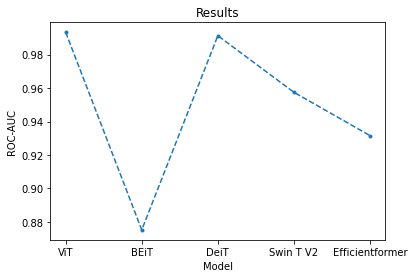

In [ ]:
plt.plot(model, eval_roc_auc, linestyle='dashed', marker = '.')
plt.title('Results')
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.show()

Best ROC-AUC score is achieved by ViT(0.9933451980705875)

# Question Answering

In [ ]:
dataset_id = "emotion"
model_1 = "sentence-transformers/paraphrase-mpnet-base-v2"
model_2 = "sentence-transformers/all-mpnet-base-v2"
model_3 = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
model_4 = "sentence-transformers/all-MiniLM-L12-v2"
model_5 = "sentence-transformers/distiluse-base-multilingual-cased-v2"

In [ ]:
!pip install datasets
from datasets import load_dataset

reference_dataset = load_dataset(dataset_id)
reference_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.7 MB/s eta 0:00:00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# Extract ClassLabel feature from "label" column
label_features = reference_dataset["train"].features["label"]
# Label names to classify with
candidate_labels = label_features.names
candidate_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
!pip install setfit
from datasets import Dataset
from setfit import get_templated_dataset

# A dummy dataset to fill with synthetic examples
dummy_dataset = Dataset.from_dict({})
train_dataset = get_templated_dataset(dummy_dataset, candidate_labels=candidate_labels, sample_size=8)
train_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=f7839be0b2a8f88632ed4364701bffa03f8af157a8d41c33e4fcb84c3882c19d
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

In [ ]:
train_dataset.shuffle()[:3]

{'text': ['This sentence is anger',
  'This sentence is fear',
  'This sentence is joy'],
 'label': [3, 4, 1]}

In [ ]:
from transformers import pipeline
pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
%%time
zeroshot_preds = pipe(reference_dataset["test"]["text"], batch_size=16, candidate_labels=candidate_labels)

KeyboardInterrupt: ignored

In [ ]:
zeroshot_preds[0]

NameError: ignored

In [ ]:
preds = [label_features.str2int(pred["labels"][0]) for pred in zeroshot_preds]

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
transformers_metrics = metric.compute(predictions=preds, references=reference_dataset["test"]["label"])
transformers_metrics